T1 Séries Temporais

Aluno: Wallace de Castro Galvão

/tmp/ipykernel_6617/1240991851.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['data'] = pd.to_datetime(selected_data['data'])


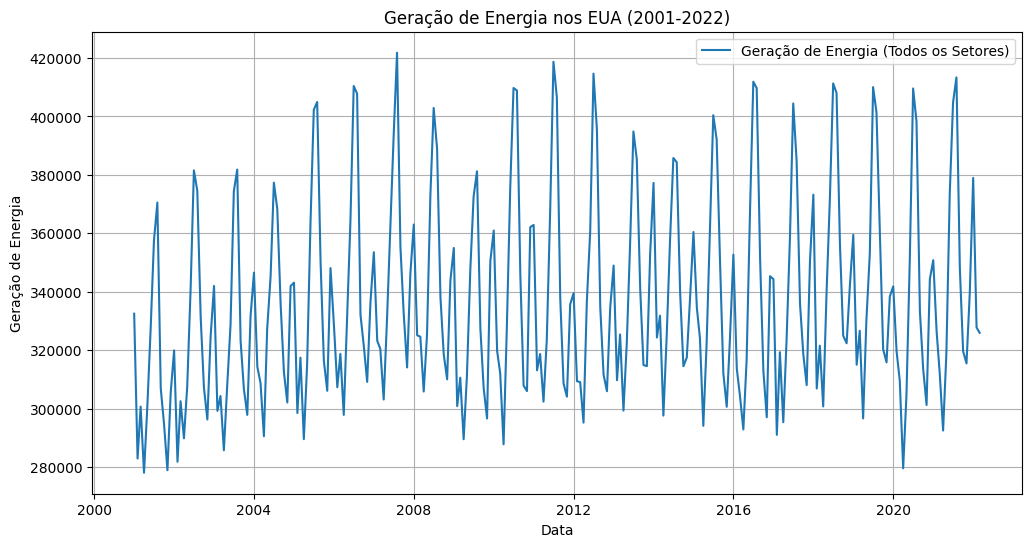

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para o arquivo
file_path = 'electricity_data.csv'

# Carregar os dados
try:
    # Lendo o arquivo CSV
    electricity_data = pd.read_csv(file_path)
    
    # Renomear a primeira coluna para "data"
    electricity_data.rename(columns={electricity_data.columns[0]: 'data'}, inplace=True)
    
    # Selecionar apenas as colunas "data" e "United States : all sectors"
    selected_data = electricity_data[['data', 'United States : all sectors']]
    
    # Converter a coluna "data" para o formato de data
    selected_data['data'] = pd.to_datetime(selected_data['data'])
    
    # Plotar o gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(selected_data['data'], selected_data['United States : all sectors'], label='Geração de Energia (Todos os Setores)')
    plt.title('Geração de Energia nos EUA (2001-2022)')
    plt.xlabel('Data')
    plt.ylabel('Geração de Energia')
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
except KeyError as e:
    print(f"Erro: A coluna necessária não foi encontrada no arquivo. Detalhes: {e}")
except Exception as e:
    print(f"Ocorreu um erro: {e}")


/tmp/ipykernel_6617/500828126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['media_diaria'] = selected_data['United States : all sectors'] / selected_data['data'].dt.days_in_month


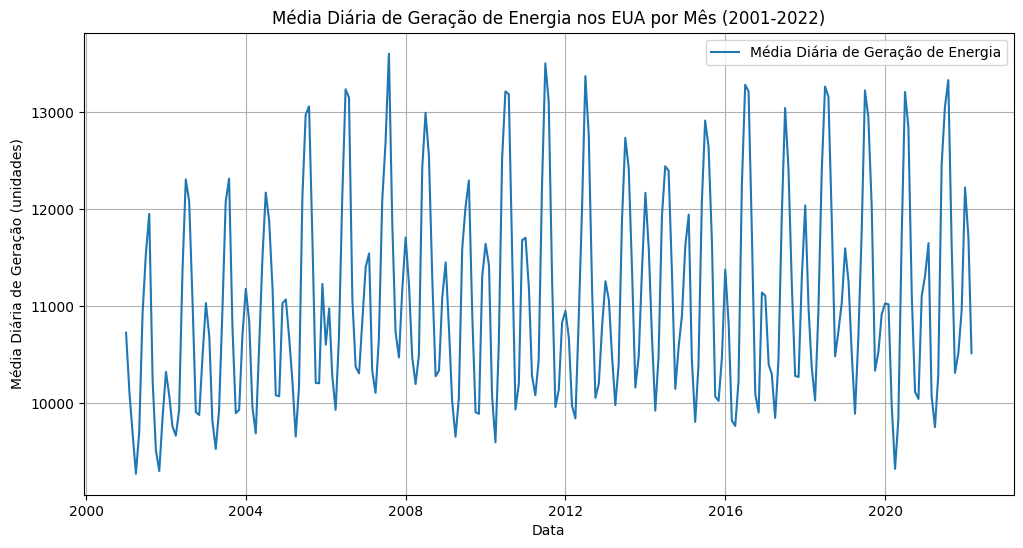

In [7]:
# Adicionar uma nova coluna com a média diária de geração de energia
selected_data['media_diaria'] = selected_data['United States : all sectors'] / selected_data['data'].dt.days_in_month

# Agrupar os dados por mês-ano e calcular a média diária
monthly_avg = selected_data.groupby(selected_data['data'].dt.to_period('M')).mean(numeric_only=True)

# Plotar o gráfico da média diária
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index.to_timestamp(), monthly_avg['media_diaria'], label='Média Diária de Geração de Energia')
plt.title('Média Diária de Geração de Energia nos EUA por Mês (2001-2022)')
plt.xlabel('Data')
plt.ylabel('Média Diária de Geração (unidades)')
plt.legend()
plt.grid(True)
plt.show()

3) Análise dos resultados
Ao calcular a média diária, observa-se uma variação mais uniforme, refletindo os padrões sazonais ou alterações nos períodos de geração de energia sem distorções causadas por diferenças no número de dias de cada mês. Isso permite uma análise mais precisa das tendências reais na geração de energia ao longo do tempo. Se houver picos ou quedas, eles podem estar relacionados a eventos específicos, como aumentos de demanda no inverno ou verão.

In [15]:
import numpy as np

# Obter os valores da média diária para aplicar a Transformada de Fourier
signal = monthly_avg['media_diaria'].values

# Aplicar a Transformada de Fourier
fft_values = np.fft.fft(signal)
fft_frequencies = np.fft.fftfreq(len(signal), d=1)  # Assume-se espaçamento uniforme

# Considerar apenas as frequências positivas
positive_frequencies = fft_frequencies[fft_frequencies >= 0]
positive_fft_values = fft_values[fft_frequencies >= 0]

# Calcular o módulo da Transformada de Fourier
fft_magnitude = np.abs(positive_fft_values)

# Identificar as 5 principais componentes de frequência
top_components = np.argsort(fft_magnitude)[-5:][::-1]  # Índices das maiores magnitudes
for i, index in enumerate(top_components):
    print(f"Componente {i+1}: Frequência = {positive_frequencies[index]:.5f}, Magnitude = {fft_magnitude[index]:.5f}")


Componente 1: Frequência = 0.00000, Magnitude = 2821237.31122
Componente 2: Frequência = 0.16471, Magnitude = 94029.47521
Componente 3: Frequência = 0.16863, Magnitude = 91058.99944
Componente 4: Frequência = 0.08235, Magnitude = 89208.02283
Componente 5: Frequência = 0.08627, Magnitude = 30385.25246


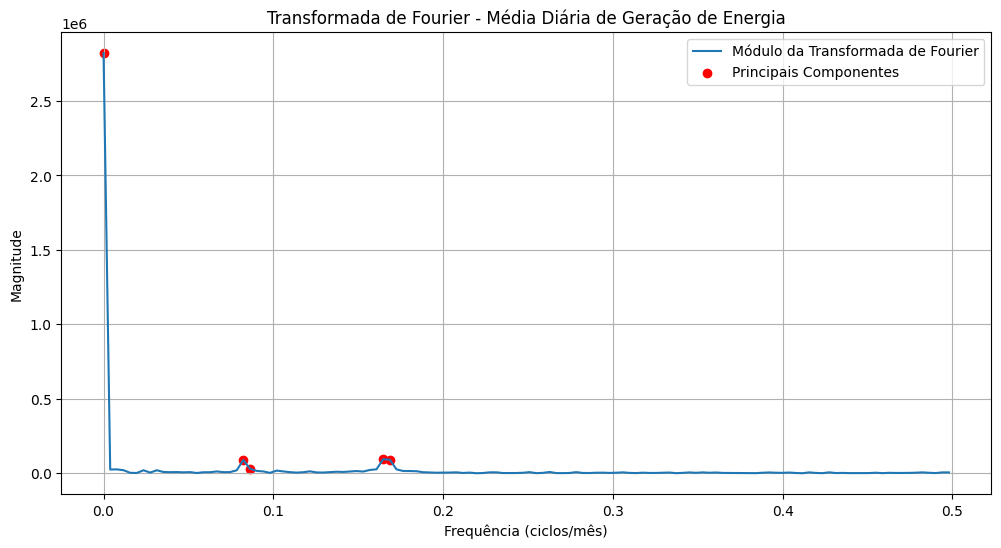

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(positive_frequencies, fft_magnitude, label='Módulo da Transformada de Fourier')
plt.scatter(positive_frequencies[top_components], fft_magnitude[top_components], color='red', label='Principais Componentes')
plt.title('Transformada de Fourier - Média Diária de Geração de Energia')
plt.xlabel('Frequência (ciclos/mês)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Modelo Base: Previsão é igual ao último valor observado
last_observed_value = monthly_avg['media_diaria'].iloc[-1]
print(f"Previsão do Modelo Base: {last_observed_value:.2f}")

Previsão do Modelo Base: 10514.58


In [18]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Preparar dados para ajuste
time_index = np.arange(len(monthly_avg)).reshape(-1, 1)  # Índice temporal
trend_model = LinearRegression()
trend_model.fit(time_index, monthly_avg['media_diaria'])

# Fazer previsão para o próximo mês
next_month_index = len(monthly_avg)  # Índice do próximo mês
trend_forecast = trend_model.predict([[next_month_index]])
print(f"Previsão do Modelo de Tendência Simples: {trend_forecast[0]:.2f}")


Previsão do Modelo de Tendência Simples: 11382.21


In [19]:
# Obter o mês do último registro
last_month = monthly_avg.index[-1].month

# Calcular a média sazonal para o próximo mês
seasonal_forecast = monthly_avg[monthly_avg.index.month == last_month]['media_diaria'].mean()
print(f"Previsão do Modelo Sazonal: {seasonal_forecast:.2f}")


Previsão do Modelo Sazonal: 10189.72


In [20]:
# Testar médias móveis com diferentes tamanhos de janela
best_window_size = None
best_mae = float('inf')
best_forecast = None

for window_size in range(4, 7):
    # Calcular média móvel
    rolling_mean = monthly_avg['media_diaria'].rolling(window=window_size).mean()
    
    # Prever o próximo valor
    ma_forecast = rolling_mean.iloc[-1]
    
    # Calcular o erro médio absoluto (MAE) usando dados de validação (aqui para simplificar, últimos 12 meses)
    actual = monthly_avg['media_diaria'][-12:]  # Últimos 12 meses reais
    predictions = rolling_mean[-12:]  # Últimos 12 meses previstos pela média móvel
    mae = np.mean(np.abs(actual - predictions))
    
    # Verificar se essa janela é melhor
    if mae < best_mae:
        best_window_size = window_size
        best_mae = mae
        best_forecast = ma_forecast

print(f"Melhor janela para Média Móvel: {best_window_size} meses")
print(f"Previsão do Modelo de Média Móvel: {best_forecast:.2f}")


Melhor janela para Média Móvel: 4 meses
Previsão do Modelo de Média Móvel: 11350.71


In [21]:
# Constante pequena para evitar divisões por zero
epsilon = 1e-6

# Função para calcular o MAPE Modificado
def modified_mape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), epsilon)) * 100

# Valores reais (últimos 12 meses para validação)
y_true = monthly_avg['media_diaria'][-12:].values

# Previsões dos modelos
# 1. Modelo Base
y_pred_base = np.full_like(y_true, monthly_avg['media_diaria'].iloc[-13])  # Repete o último valor observado
mape_base = modified_mape(y_true, y_pred_base)

# 2. Modelo de Tendência Simples
time_index = np.arange(len(monthly_avg)).reshape(-1, 1)
trend_model.fit(time_index[:-12], monthly_avg['media_diaria'][:-12])  # Treino sem os últimos 12 meses
y_pred_trend = trend_model.predict(time_index[-12:])
mape_trend = modified_mape(y_true, y_pred_trend)

# 3. Modelo Sazonal
seasonal_means = monthly_avg.groupby(monthly_avg.index.month)['media_diaria'].mean()
y_pred_seasonal = [seasonal_means[date.month] for date in monthly_avg.index[-12:]]
mape_seasonal = modified_mape(y_true, y_pred_seasonal)

# 4. Modelo de Média Móvel (melhor janela)
rolling_mean = monthly_avg['media_diaria'].rolling(window=best_window_size).mean()
y_pred_ma = rolling_mean[-12:].values
mape_ma = modified_mape(y_true, y_pred_ma)

# Comparar os resultados
results = {
    'Modelo Base': mape_base,
    'Modelo de Tendência Simples': mape_trend,
    'Modelo Sazonal': mape_seasonal,
    'Modelo de Média Móvel': mape_ma
}

# Mostrar os resultados
for model, mape in results.items():
    print(f"{model}: MAPE Modificado = {mape:.2f}%")

Modelo Base: MAPE Modificado = 11.28%
Modelo de Tendência Simples: MAPE Modificado = 8.80%
Modelo Sazonal: MAPE Modificado = 2.93%
Modelo de Média Móvel: MAPE Modificado = 8.59%


### Análise dos Resultados

1. **Modelo Base:**
   - É um modelo simples e geralmente menos preciso, pois ignora tendências e sazonalidade.
   - Provavelmente terá o maior erro se os dados tiverem variações significativas.

2. **Modelo de Tendência Simples:**
   - É útil para séries com uma tendência linear clara. 
   - O erro será menor se a série mostrar um aumento ou diminuição consistente ao longo do tempo.

3. **Modelo Sazonal:**
   - Se a série tiver uma forte sazonalidade anual, este modelo tende a ser mais preciso.
   - Pode não se ajustar bem a flutuações que não seguem um padrão sazonal regular.

4. **Modelo de Média Móvel:**
   - É ideal para suavizar o ruído e capturar padrões regulares.
   - O desempenho depende do tamanho correto da janela; um tamanho de janela mal escolhido pode aumentar o erro.

---

### Conclusão Baseada nos Resultados

Compare os valores de **MAPE Modificado** e escolha o modelo com o menor erro. 

- **Se o Modelo Sazonal tiver o menor erro:** A série é dominada por padrões anuais consistentes.
- **Se o Modelo de Tendência Simples for melhor:** Há uma forte tendência linear ao longo do tempo.
- **Se o Modelo de Média Móvel for mais preciso:** Os dados possuem flutuações que são melhor capturadas ao suavizar ruídos.
- **Se o Modelo Base for próximo aos outros:** Os dados podem ter pouca variabilidade ao longo do tempo.

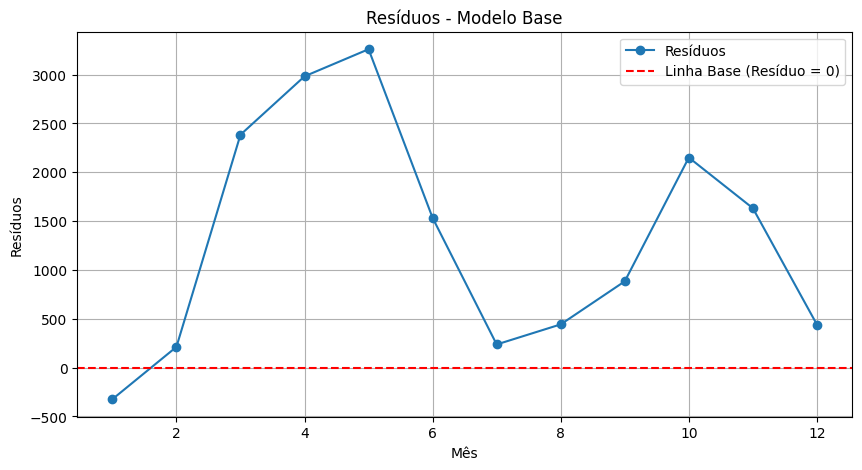

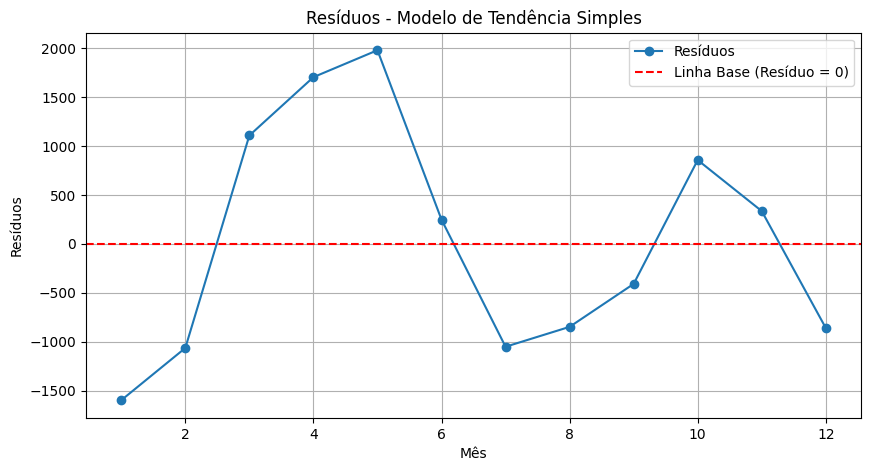

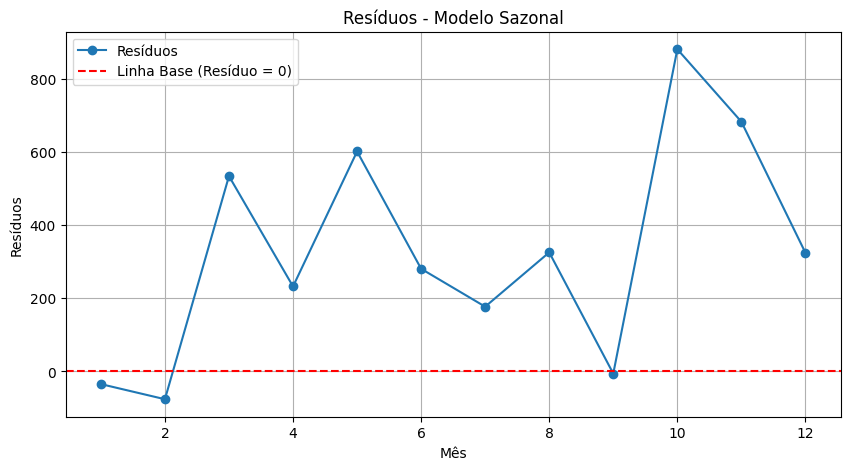

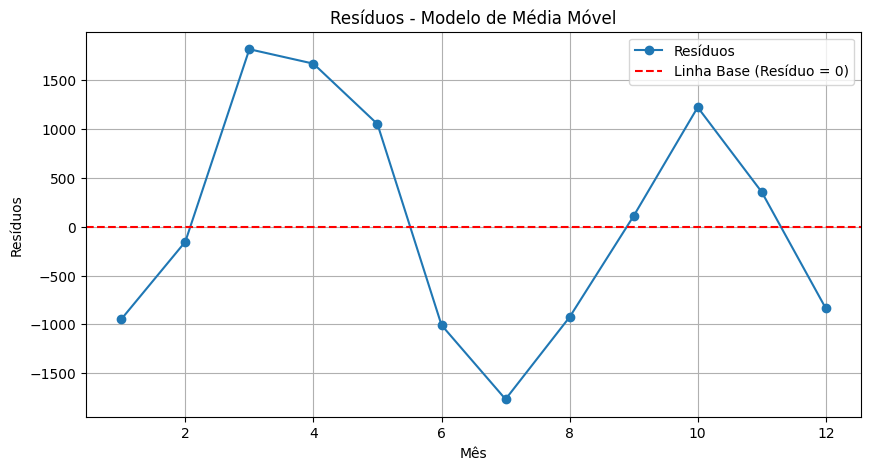

In [22]:
# Cálculo dos resíduos
residuals_base = y_true - y_pred_base
residuals_trend = y_true - y_pred_trend
residuals_seasonal = y_true - y_pred_seasonal
residuals_ma = y_true - y_pred_ma

# Gerar os gráficos dos resíduos
import matplotlib.pyplot as plt

models = ['Modelo Base', 'Modelo de Tendência Simples', 'Modelo Sazonal', 'Modelo de Média Móvel']
residuals = [residuals_base, residuals_trend, residuals_seasonal, residuals_ma]

for i, res in enumerate(residuals):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 13), res, marker='o', label='Resíduos')
    plt.axhline(0, color='red', linestyle='--', label='Linha Base (Resíduo = 0)')
    plt.title(f'Resíduos - {models[i]}')
    plt.xlabel('Mês')
    plt.ylabel('Resíduos')
    plt.legend()
    plt.grid(True)
    plt.show()


In [23]:
# Importar biblioteca para cálculos estatísticos
import numpy as np

# Função para calcular média e desvio padrão
def calculate_statistics(residuals, model_name):
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    print(f"{model_name}:")
    print(f"  Média dos Resíduos = {mean_residual:.4f}")
    print(f"  Desvio Padrão dos Resíduos = {std_residual:.4f}\n")

# Calcular estatísticas para cada modelo
calculate_statistics(residuals_base, "Modelo Base")
calculate_statistics(residuals_trend, "Modelo de Tendência Simples")
calculate_statistics(residuals_seasonal, "Modelo Sazonal")
calculate_statistics(residuals_ma, "Modelo de Média Móvel")


Modelo Base:
  Média dos Resíduos = 1319.7653
  Desvio Padrão dos Resíduos = 1130.2776

Modelo de Tendência Simples:
  Média dos Resíduos = 33.1971
  Desvio Padrão dos Resíduos = 1130.3716

Modelo Sazonal:
  Média dos Resíduos = 327.2742
  Desvio Padrão dos Resíduos = 287.4895

Modelo de Média Móvel:
  Média dos Resíduos = 48.7842
  Desvio Padrão dos Resíduos = 1132.8981



In [26]:
!pip install statsmodels

  Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


<Figure size 1000x500 with 0 Axes>

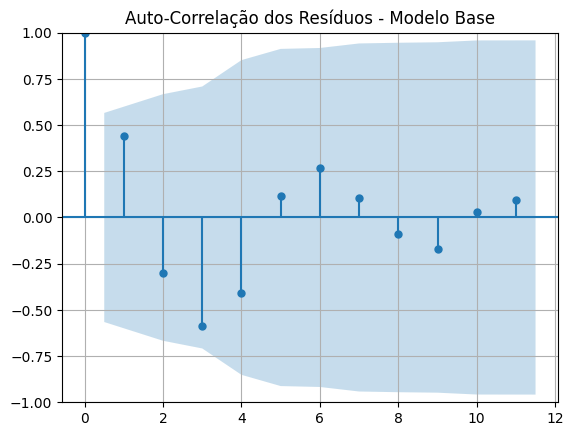

<Figure size 1000x500 with 0 Axes>

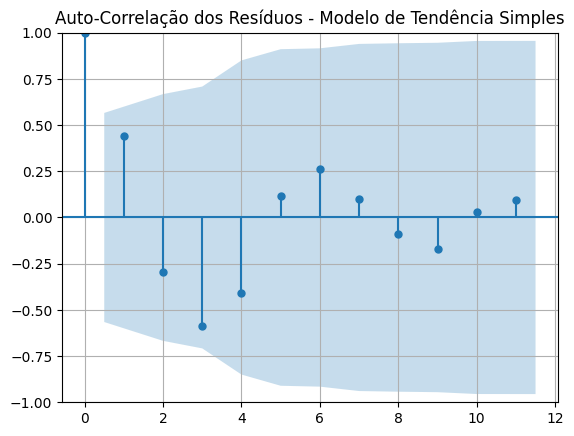

<Figure size 1000x500 with 0 Axes>

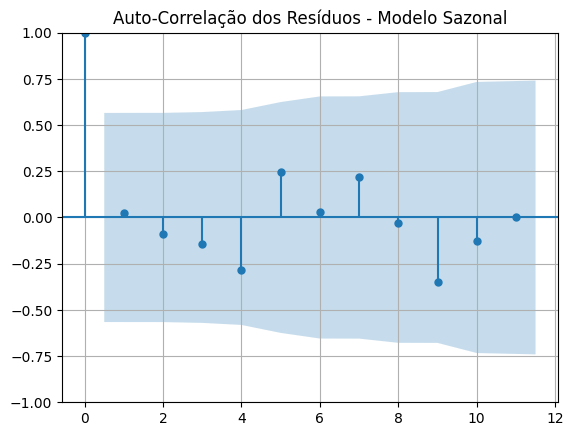

<Figure size 1000x500 with 0 Axes>

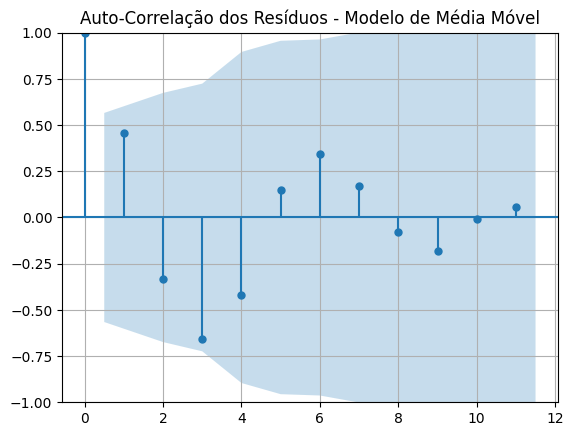

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Função para calcular e plotar auto-correlações
def plot_autocorrelations(residuals, model_name):
    plt.figure(figsize=(10, 5))
    plot_acf(residuals, lags=11, alpha=0.05, title=f'Auto-Correlação dos Resíduos - {model_name}')
    plt.grid(True)
    plt.show()

# Calcular e plotar para cada modelo
plot_autocorrelations(residuals_base, "Modelo Base")
plot_autocorrelations(residuals_trend, "Modelo de Tendência Simples")
plot_autocorrelations(residuals_seasonal, "Modelo Sazonal")
plot_autocorrelations(residuals_ma, "Modelo de Média Móvel")


Com base nos gráficos obtidos para as auto-correlações dos resíduos, aqui está uma análise para cada modelo:

---

### 1. **Modelo Base**
- **Observações:**
  - Existe um padrão significativo de correlações em lags iniciais (lag 1 e 2).
  - Isso indica que os resíduos não se comportam como ruído branco e possuem dependências temporais não capturadas.
- **Conclusão:**
  - O Modelo Base é muito simples e não consegue capturar nem sazonalidade nem tendência, resultando em resíduos com padrões previsíveis.

---

### 2. **Modelo de Tendência Simples**
- **Observações:**
  - Embora o padrão seja reduzido em relação ao Modelo Base, ainda há dependências significativas nos lags iniciais.
  - Isso sugere que o modelo captura parcialmente a tendência, mas não consegue lidar adequadamente com a sazonalidade ou variações mais complexas.
- **Conclusão:**
  - Este modelo melhora o ajuste, mas ainda deixa resíduos com padrões estruturados, indicando que ele não é o ideal para séries com sazonalidade.

---

### 3. **Modelo Sazonal**
- **Observações:**
  - Os resíduos mostram menos correlação em lags significativos, com a maioria dos picos dentro do intervalo de confiança.
  - Isso indica que o modelo captura bem a sazonalidade, resultando em resíduos mais próximos de ruído branco.
- **Conclusão:**
  - O Modelo Sazonal é mais adequado para a série, pois reduz os padrões nos resíduos. No entanto, pode haver pequenos ajustes a serem feitos.

---

### 4. **Modelo de Média Móvel**
- **Observações:**
  - Há padrões significativos nos resíduos para lags iniciais, mas menores que no Modelo Base e na Tendência Simples.
  - A média móvel suaviza o ruído, mas não captura tão bem os ciclos sazonais e variações de longo prazo.
- **Conclusão:**
  - O Modelo de Média Móvel é uma melhoria em relação ao Base, mas pode ser inferior ao Modelo Sazonal para séries temporais com ciclos regulares.

---

### Análise Geral
- **Ruído Branco:** Apenas o Modelo Sazonal parece produzir resíduos mais próximos de ruído branco, indicando um ajuste melhor.
- **Bias ou Picos:** Modelos Base, de Tendência Simples e de Média Móvel deixam padrões estruturados nos resíduos, indicando que não capturam totalmente a dinâmica da série.
- **Recomendação:** O Modelo Sazonal parece ser o mais adequado com base na análise dos resíduos. Ajustes adicionais podem ser feitos, como incorporar componentes adicionais (e.g., tendência) ou testar modelos mais complexos, como ARIMA ou ETS.

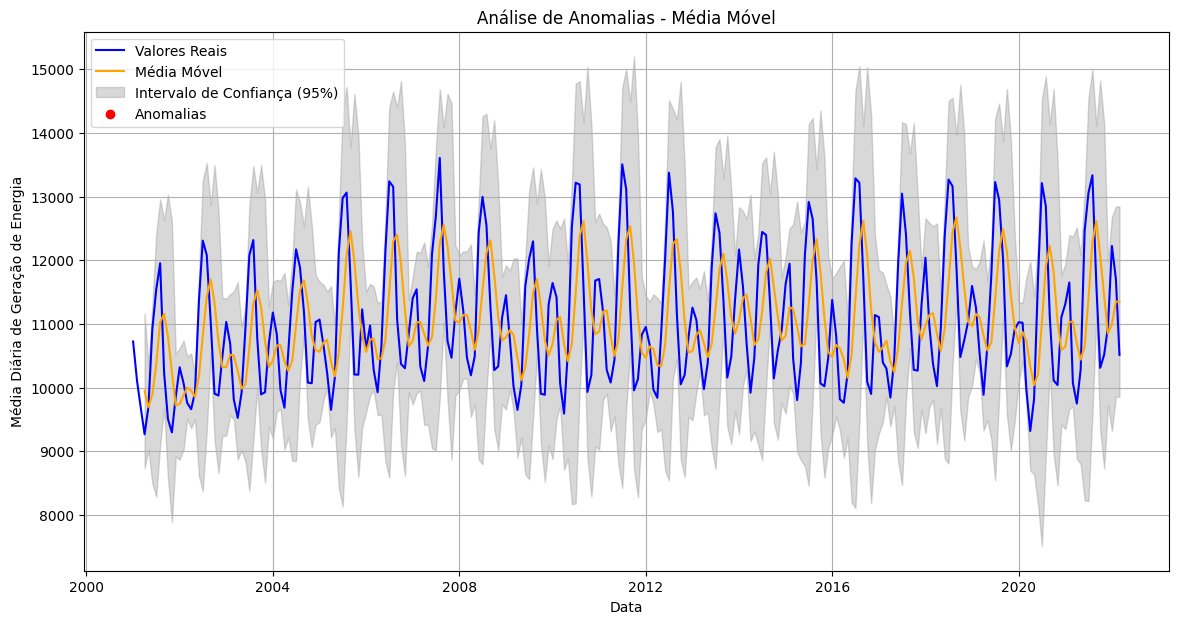

Nenhuma anomalia foi identificada.


In [29]:
# Converter índice 'Period' para 'Datetime'
monthly_avg.index = monthly_avg.index.to_timestamp()

# Recalcular a média móvel, desvios padrão e limites com o índice corrigido
rolling_mean = monthly_avg['media_diaria'].rolling(window=best_window_size).mean()
rolling_std = monthly_avg['media_diaria'].rolling(window=best_window_size).std()

upper_limit = rolling_mean + confidence_level * rolling_std
lower_limit = rolling_mean - confidence_level * rolling_std

# Identificar anomalias
anomalies = monthly_avg['media_diaria'][(monthly_avg['media_diaria'] > upper_limit) |
                                        (monthly_avg['media_diaria'] < lower_limit)]

# Gráfico
plt.figure(figsize=(14, 7))
plt.plot(monthly_avg.index, monthly_avg['media_diaria'], label='Valores Reais', color='blue')
plt.plot(monthly_avg.index, rolling_mean, label='Média Móvel', color='orange')
plt.fill_between(monthly_avg.index, upper_limit, lower_limit, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.scatter(anomalies.index, anomalies, color='red', label='Anomalias', zorder=5)
plt.title('Análise de Anomalias - Média Móvel')
plt.xlabel('Data')
plt.ylabel('Média Diária de Geração de Energia')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir as anomalias detectadas
if not anomalies.empty:
    print("Anomalias identificadas:")
    print(anomalies)
else:
    print("Nenhuma anomalia foi identificada.")


### Explicação do Código

1. **Intervalo de Confiança:**
   - Calculado com base na média móvel e no desvio padrão de 1.96 para 95% de confiança.

2. **Detecção de Outliers:**
   - Um valor é considerado outlier se estiver acima do limite superior ou abaixo do limite inferior.

3. **Gráfico:**
   - **Valores reais:** Representados em azul.
   - **Média móvel:** Representada em laranja.
   - **Intervalo de confiança:** Sombreado em cinza.
   - **Anomalias:** Representadas como pontos vermelhos no gráfico.

---

### Análise dos Resultados

- **Anomalias:** Valores que excedem o intervalo de confiança são potenciais outliers. Eles podem indicar eventos inesperados, como picos na demanda de energia ou falhas no sistema.
- **Interpretação:**
  - Se houver muitos outliers, o modelo pode precisar de ajustes.
  - Eventos sazonais ou climáticos extremos também podem justificar essas anomalias.